#### Packages 

In [1]:
import pandas as pd
from pycaret.classification import *
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import mlflow
from sklearn.model_selection import train_test_split
import os
from sklearn.metrics import average_precision_score
from sklearn.utils import shuffle
from model_utils import *

In [2]:
mlflow.set_tracking_uri("http://localhost:5000")

#### Install Optuna and Scikit optmize

In [3]:
'''Install Optuna and Scikit-Optimize if not installed already'''
# %pip install optuna
# %pip install scikit-optimize

'Install Optuna and Scikit-Optimize if not installed already'

In [4]:
df_train, df_test = get_raw_data()

In [6]:
clf1 = setup(data = df_train, 
             target = 'target',
             numeric_features=df_train.columns[0:-1].to_list(),
             silent=True,
             log_experiment = True,
             use_gpu=False,
             experiment_name = 'selected_model',
             fix_imbalance = True, 
             transformation = True, 
             polynomial_features = True,
             feature_selection = True, feature_selection_threshold = 0.5,
             remove_multicollinearity = True, multicollinearity_threshold = 0.6,
            )
add_metric('apc', 'APC', average_precision_score, target = 'pred_proba')
best = compare_models(sort="APC", 
                      include=["lightgbm", "et", "rf", "lr", "gbc"])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC,TT (Sec)
et,Extra Trees Classifier,0.9763,0.9836,0.8733,0.9597,0.9122,0.8986,0.9014,0.9547,0.2320
lightgbm,Light Gradient Boosting Machine,0.9712,0.9809,0.8779,0.9191,0.8963,0.8796,0.8810,0.9530,1.3890
rf,Random Forest Classifier,0.9764,0.9798,0.8872,0.9457,0.9139,0.9003,0.9019,0.9514,0.5670
gbc,Gradient Boosting Classifier,0.9668,0.9778,0.8824,0.8884,0.8832,0.8639,0.8653,0.9500,1.7720
lr,Logistic Regression,0.9533,0.9747,0.9142,0.7941,0.8489,0.8216,0.8251,0.9450,0.0350


In [7]:
clf1

(-1,
 120736    0
 161891    0
 156656    0
 101018    0
 38119     0
          ..
 11507     0
 134119    0
 98817     0
 15852     0
 170041    0
 Name: target, Length: 672, dtype: int64,
 {'acc': <pycaret.containers.metrics.classification.AccuracyMetricContainer at 0x119296be3d0>,
  'auc': <pycaret.containers.metrics.classification.ROCAUCMetricContainer at 0x119296be400>,
  'recall': <pycaret.containers.metrics.classification.RecallMetricContainer at 0x119296be490>,
  'precision': <pycaret.containers.metrics.classification.PrecisionMetricContainer at 0x119296be5e0>,
  'f1': <pycaret.containers.metrics.classification.F1MetricContainer at 0x119296be730>,
  'kappa': <pycaret.containers.metrics.classification.KappaMetricContainer at 0x119296be880>,
  'mcc': <pycaret.containers.metrics.classification.MCCMetricContainer at 0x119296be910>,
  'apc': <pycaret.containers.metrics.classification.ClassificationMetricContainer at 0x1190f9698b0>},
 None,
 None,
             Time        V1        V

In [8]:
best

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=1910, verbose=0,
                     warm_start=False)

In [9]:
results = predict_model(best, raw_score=True,data = df_test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
0,Extra Trees Classifier,0.9791,0.9796,0.8830,0.9805,0.9292,0.9170,0.9188,0.9578


#### Hyperparameter tuning
Define search space for hyper parameter tuning

In [10]:
params = {"max_depth": np.random.randint(1, 40, 10),
          "n_estimators": np.random.randint(2, 1000, 10)}
          
# tune model
tuned_dt = tune_model(best, custom_grid = params)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
Fold,,,,,,,,
0,0.9745,0.9835,0.8182,1.0000,0.9000,0.8856,0.8914,0.9526
1,0.9873,0.9980,0.9545,0.9545,0.9545,0.9471,0.9471,0.9903
2,0.9682,0.9771,0.9091,0.8696,0.8889,0.8703,0.8706,0.9563
3,0.9745,0.9796,0.8696,0.9524,0.9091,0.8943,0.8956,0.9524
4,0.9936,1.0000,0.9565,1.0000,0.9778,0.9741,0.9744,1.0000
5,0.9744,0.9742,0.8636,0.9500,0.9048,0.8900,0.8913,0.9523
6,0.9744,0.9657,0.8636,0.9500,0.9048,0.8900,0.8913,0.9240
7,0.9744,0.9969,0.8182,1.0000,0.9000,0.8855,0.8913,0.9838
8,0.9679,0.9691,0.7727,1.0000,0.8718,0.8538,0.8631,0.8962


In [11]:
tuned_dt

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=8, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=559, n_jobs=-1,
                     oob_score=False, random_state=1910, verbose=0,
                     warm_start=False)

In [12]:
results = predict_model(tuned_dt, data=df_test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
0,Extra Trees Classifier,0.9746,0.9783,0.8772,0.9554,0.9146,0.8998,0.9009,0.9544


#### Voting classifier

In [13]:
tops= compare_models(n_select = 3, sort="APC")
tops

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC,TT (Sec)
et,Extra Trees Classifier,0.9763,0.9836,0.8733,0.9597,0.9122,0.8986,0.9014,0.9547,0.2950
lightgbm,Light Gradient Boosting Machine,0.9712,0.9809,0.8779,0.9191,0.8963,0.8796,0.8810,0.9530,0.2060
rf,Random Forest Classifier,0.9764,0.9798,0.8872,0.9457,0.9139,0.9003,0.9019,0.9514,0.4780
gbc,Gradient Boosting Classifier,0.9668,0.9778,0.8824,0.8884,0.8832,0.8639,0.8653,0.9500,1.2180
ada,Ada Boost Classifier,0.9642,0.9739,0.9231,0.8454,0.8805,0.8596,0.8622,0.9482,0.3810
lr,Logistic Regression,0.9533,0.9747,0.9142,0.7941,0.8489,0.8216,0.8251,0.9450,0.0770
lda,Linear Discriminant Analysis,0.9623,0.9757,0.8913,0.8547,0.8700,0.8481,0.8500,0.9379,0.0280
qda,Quadratic Discriminant Analysis,0.9655,0.9479,0.8599,0.8997,0.8756,0.8557,0.8584,0.8888,0.0300
knn,K Neighbors Classifier,0.9521,0.9644,0.9095,0.7916,0.8443,0.8162,0.8205,0.8779,0.0670
nb,Naive Bayes,0.9655,0.9729,0.8733,0.8841,0.8767,0.8567,0.8580,0.8690,0.0240


[ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                      criterion='gini', max_depth=None, max_features='auto',
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=1910, verbose=0,
                      warm_start=False),
 LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                importance_type='split', learning_rate=0.1, max_depth=-1,
                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
                random_state=1910, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
                subsample=1.0, subsample_for_bin=200000, subsample_fr

In [14]:
tops[0]

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=1910, verbose=0,
                     warm_start=False)

In [15]:
blender_weighted = blend_models([tops[0],tops[1],tops[2]], weights = [0.5,0.3,0.2])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
Fold,,,,,,,,
0,0.9745,0.9929,0.8182,1.0000,0.9000,0.8856,0.8914,0.9739
1,0.9873,0.9966,0.9545,0.9545,0.9545,0.9471,0.9471,0.9858
2,0.9682,0.9842,0.9091,0.8696,0.8889,0.8703,0.8706,0.9548
3,0.9745,0.9737,0.9130,0.9130,0.9130,0.8981,0.8981,0.9441
4,0.9873,0.9997,0.9565,0.9565,0.9565,0.9491,0.9491,0.9982
5,0.9808,0.9695,0.9091,0.9524,0.9302,0.9191,0.9194,0.9560
6,0.9615,0.9685,0.8636,0.8636,0.8636,0.8412,0.8412,0.9283
7,0.9872,0.9925,0.9091,1.0000,0.9524,0.9450,0.9464,0.9757
8,0.9551,0.9688,0.7727,0.8947,0.8293,0.8036,0.8065,0.8939


In [16]:
tops= compare_models(n_select = 2)
blender = blend_models(tops)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
Fold,,,,,,,,
0,0.9745,0.9923,0.8182,1.0000,0.9000,0.8856,0.8914,0.9686
1,0.9936,0.9970,0.9545,1.0000,0.9767,0.9731,0.9734,0.9868
2,0.9618,0.9845,0.9091,0.8333,0.8696,0.8472,0.8483,0.9584
3,0.9682,0.9729,0.8696,0.9091,0.8889,0.8703,0.8706,0.9434
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,0.9744,0.9707,0.8636,0.9500,0.9048,0.8900,0.8913,0.9556
6,0.9679,0.9676,0.8636,0.9048,0.8837,0.8651,0.8655,0.9295
7,0.9808,0.9929,0.8636,1.0000,0.9268,0.9158,0.9191,0.9778
8,0.9679,0.9673,0.7727,1.0000,0.8718,0.8538,0.8631,0.8900


#### Hyperparameter tuning with scikit-optimize on voting model

PyCaret integrates seamlessly with many different libraries for hyperparameter tuning. This gives you access to many different types of search algorithms including random, bayesian, optuna, TPE, and a few others. All of this just by changing a parameter. By default, PyCaret using RandomGridSearch from the sklearn and you can change that by using search_library and search_algorithm parameter in the tune_model function.

In [17]:
tuned_dt = tune_model(blender_weighted, search_library = 'scikit-optimize', optimize="APC", n_iter = 50) # https://pycaret.readthedocs.io/en/stable/api

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
Fold,,,,,,,,
0,0.9745,0.9953,0.8182,1.0000,0.9000,0.8856,0.8914,0.9800
1,0.9936,0.9963,0.9545,1.0000,0.9767,0.9731,0.9734,0.9848
2,0.9682,0.9916,0.9091,0.8696,0.8889,0.8703,0.8706,0.9688
3,0.9745,0.9776,0.9130,0.9130,0.9130,0.8981,0.8981,0.9497
4,0.9873,0.9997,0.9565,0.9565,0.9565,0.9491,0.9491,0.9982
5,0.9744,0.9688,0.8636,0.9500,0.9048,0.8900,0.8913,0.9543
6,0.9615,0.9695,0.8636,0.8636,0.8636,0.8412,0.8412,0.9256
7,0.9808,0.9932,0.8636,1.0000,0.9268,0.9158,0.9191,0.9784
8,0.9615,0.9732,0.7727,0.9444,0.8500,0.8282,0.8337,0.9040


In [18]:
results = predict_model(tuned_dt, raw_score=True, data=df_test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
0,Voting Classifier,0.9773,0.9807,0.8947,0.9562,0.9245,0.9112,0.9119,0.9605


In [19]:
save_model(tuned_dt, 'tuned_dt')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=['Time', 'V1', 'V2',
                                                           'V3', 'V4', 'V5',
                                                           'V6', 'V7', 'V8',
                                                           'V9', 'V10', 'V11',
                                                           'V12', 'V13', 'V14',
                                                           'V15', 'V16', 'V17',
                                                           'V18', 'V19', 'V20',
                                                           'V21', 'V22', 'V23',
                                                   

In [20]:
evaluate_model(tuned_dt)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

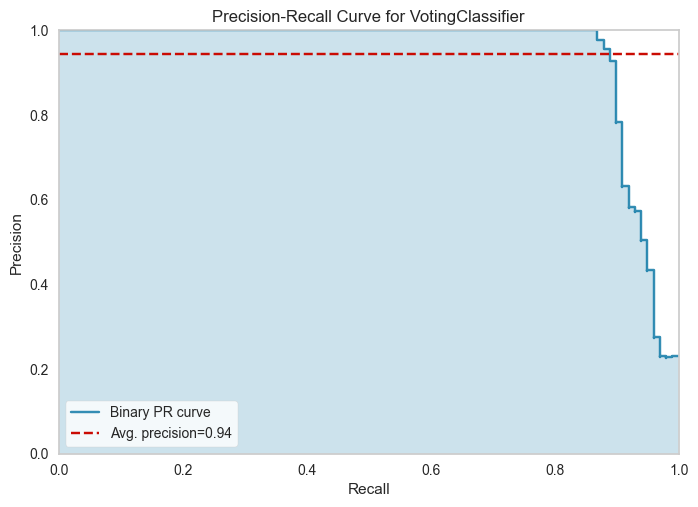

In [21]:
plot_model(tuned_dt, plot = 'pr')

#### Create REST API

In [20]:
# %pip install fastapi
# %pip install uvicorn

In [23]:
create_api(tuned_dt, 'fraud_voting_model_api')


API sucessfully created. This function only creates a POST API, it doesn't run it automatically.

To run your API, please run this command --> !python fraud_voting_model_api.py
    


In [28]:
# run the API
!python fraud_voting_model_api.py

^C


In [ ]:
df_test.iloc[-1].to_dict()

Time      41991.000000
V1           -4.566342
V2            3.353451
V3           -4.572028
V4            3.616119
V5           -2.493138
V6           -1.090000
V7           -5.551433
V8            0.447783
V9           -2.424414
V10          -5.699922
V11           3.586824
V12          -6.636229
V13          -1.128176
V14          -7.245550
V15           0.638326
V16          -6.856810
V17          -8.851879
V18          -4.591883
V19           0.936940
V20          -0.249128
V21           2.674466
V22          -0.020880
V23          -0.302447
V24          -0.086396
V25          -0.516060
V26          -0.295102
V27           0.195985
V28           0.141115
Amount        1.000000
target        1.000000
Name: 44556, dtype: float64

#### Create Docker

In [23]:
create_docker('fraud_voting_model_api')

Writing requirements.txt
Writing Dockerfile
Dockerfile and requirements.txt successfully created.
To build image you have to run --> !docker image build -f "Dockerfile" -t IMAGE_NAME:IMAGE_TAG .
        


In [25]:
# !docker image build -f Dockerfile -t fraud_voting_model_api:latest .
!docker image build -f "Dockerfile" -t fraud_voting_model_api:latest .

#1 [internal] load build definition from Dockerfile
#1 sha256:752698380b6c52a095d1b1c921ffead9cacd4aaa74c6ff997fef4ad1760a5b4e
#1 transferring dockerfile: 257B 0.1s done
#1 DONE 0.1s

#2 [internal] load .dockerignore
#2 sha256:b73c4a17d0600d238eee13d5e75cd3dd5369e77e6104083c1945587da491786a
#2 transferring context: 2B done
#2 DONE 0.0s

#3 [internal] load metadata for docker.io/library/python:3.8-slim
#3 sha256:a94c831f6b826f8ffd4325edd7e9f6408caa85fd7f03e2b107cc6a9d249f7065
#3 ...

#4 [auth] library/python:pull token for registry-1.docker.io
#4 sha256:5cba492fb01746c3dc45d5cabca61d6fe9bcb472e3c686e7dee90534df5e90e7
#4 DONE 0.0s

#3 [internal] load metadata for docker.io/library/python:3.8-slim
#3 sha256:a94c831f6b826f8ffd4325edd7e9f6408caa85fd7f03e2b107cc6a9d249f7065
#3 DONE 3.8s

#10 [1/5] FROM docker.io/library/python:3.8-slim@sha256:1222aecd5ea9214a0ca4761e21f9f36d119c55a5a3721cd06da58e7199e79f2e
#10 sha256:7a2ab8c8bb7b2edf5e64b18c26918875d8baf851f9ffeb85421198067ec59878
#10 DONE 0

In [28]:
''' 
This command is running the docker image that we just built. 
The `-d` flag means that the container will run in the background. 
The `-p` flag means that we are mapping the port 8000 on the host machine to port 8000 on the container. 
The `--name` flag means that we are naming the container `fraud_voting_model_api`. 
The last argument is the name of the image that we want to run.
'''
!docker run -d -p 8000:8000 --name fraud_voting_model_api fraud_voting_model_api:latest

1140b98eb6e96c9c9bdbd3e83cb4dd6488d32afa0e1f4aba5d6f82510098f9b7
